In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import sentencepiece as spm


import string
import re
import random
import numpy as np
import os

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import sentencepiece as spm

from word2vector import Vocab
from EncoderRNN import EncoderRNN
from Attention import Attn
from DecoderRNN import DecoderRNN
from Data_reading import input_data
from Pretrained_embedding import pre_embedding
import Train
from textCNN import textCNN

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

cuda:2


In [2]:
sp_user = spm.SentencePieceProcessor()
sp_user.load('m.model')


True

In [3]:
MAX_LEN = 40
src_train, src_train_lens, tgt_train, tgt_train_lens, src_val, src_val_lens, tgt_val, tgt_val_lens =  input_data(sp_user, MAX_LEN)

src_train (98634, 40)
src_train_lens (98634,)
tgt_train (98634, 40)
tgt_train_lens (98634,)
src_val (4962, 40)
src_val_lens (4962,)
tgt_val (4962, 40)
tgt_val_lens (4962,)


In [4]:
# import matplotlib.pyplot as plt

In [5]:
# plt.hist(src_train_lens, np.max(src_train_lens))

In [6]:
# plt.hist(tgt_train_lens[tgt_train_lens<100], 100)

In [7]:
# plt.hist(src_val_lens, np.max(src_val_lens))

In [8]:
# plt.hist(tgt_val_lens, np.max(tgt_val_lens))

In [9]:
# test = np.arange(2000)
# formal_train_tensors = torch.LongTensor(src_train[test]).to(device)
# formal_train_lens_tensors = torch.LongTensor(src_train_lens[test]).to(device)
# informal_train_tensors = torch.LongTensor(tgt_train[test]).to(device)
# informal_train_lens_tensors = torch.LongTensor(tgt_train_lens[test]).to(device)

# test_1= np.arange(1000)
# formal_val_tensors = torch.LongTensor(src_val[test_1]).to(device)
# formal_val_lens_tensors = torch.LongTensor(src_val_lens[test_1]).to(device)
# informal_val_tensors = torch.LongTensor(tgt_val[test_1]).to(device)
# informal_val_lens_tensors = torch.LongTensor(tgt_val_lens[test_1]).to(device)

formal_train_tensors = torch.LongTensor(src_train).to(device)
formal_train_lens_tensors = torch.LongTensor(src_train_lens).to(device)
informal_train_tensors = torch.LongTensor(tgt_train).to(device)
informal_train_lens_tensors = torch.LongTensor(tgt_train_lens).to(device)

formal_val_tensors = torch.LongTensor(src_val).to(device)
formal_val_lens_tensors = torch.LongTensor(src_val_lens).to(device)
informal_val_tensors = torch.LongTensor(tgt_val).to(device)
informal_val_lens_tensors = torch.LongTensor(tgt_val_lens).to(device)

In [10]:
embedding_dim = 100
num_layer = 4
dropout = 0.5
hidden_dim = 128
batch_size = 64
learning_rate=0.001
vocab_size = sp_user.get_piece_size() #len(Glove.word2index)
#embedding=None
attn = 'general'
style_1 = sp_user.piece_to_id('<informal>')
style_2 = sp_user.piece_to_id('<formal>')

embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)

encoder = EncoderRNN(embedding=embedding, vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, device=device ,
                     num_layer=num_layer, dropout=dropout).to(device)

decoder = DecoderRNN(embedding=embedding, attn_model=attn, vocab_size=vocab_size, embedding_dim=embedding_dim, 
                     hidden_dim=hidden_dim, device=device , num_layer=num_layer, dropout=dropout).to(device)

textCNN = textCNN(seq_length=MAX_LEN, embedding_size=embedding_dim, 
                  num_labels=2, embedding=embedding, filter_sizes=[3, 4, 5], drop_out_rate=0.5, num_feature_maps=500).to(device)

encoder_optimizer = optim.Adam(encoder.parameters(),lr=learning_rate)

decoder_optimizer = optim.Adam(decoder.parameters(),lr=learning_rate)

cnn_optimizer = optim.Adam(textCNN.parameters(),lr=learning_rate)







0.33333333333333337
iter 1
1984/2000, reconstruction loss: 18.69808578491211 classication loss: 0.07246771454811096 classfication accuracy: 0.65625
Evalidation: 960/1000, loss:16.320494079589842 classication loss: 0.02457658350467682 classfication accuracy: 0.7875
0m 19s (- 0m 39s) /ntrain rec loss: 21.897.  val rec loss: 0.022. /ntrain cnn loss: 0.022.  val cnn loss: 0.017. /ntrain cnn acc: 0.620.  val cnn acc: 0.727. 
val loss decreases from 100.000 to 14.960, save models
val cnn acc increase from 0.000 to 0.727, save models
women are acquisitive . give them both and they will say , " it is not working well enough , darling ."


women are greedy , give them the both , and they will say , it isnot working good enough , honey



-0.33333333333333326
iter 2
1984/2000, reconstruction loss: 18.05624771118164 classication loss: 0.03665769472718239 classfication accuracy: 0.84375
Evalidation: 960/1000, loss:15.368641662597657 classication loss: 0.022864575684070586 classfication accuracy: 0

<Figure size 432x288 with 0 Axes>

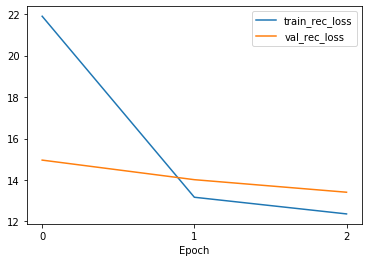

<Figure size 432x288 with 0 Axes>

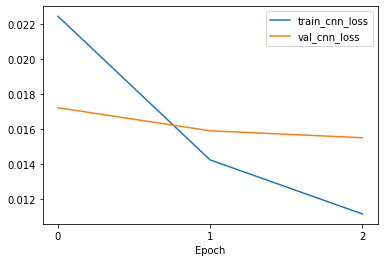

<Figure size 432x288 with 0 Axes>

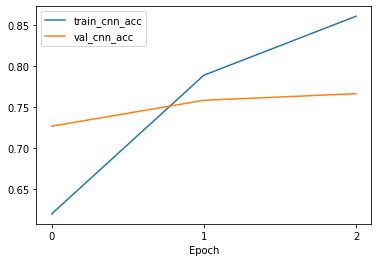

In [11]:
output_seq, plot_train_rec_loss,plot_val_rec_loss,plot_train_cnn_loss,plot_val_cnn_loss,plot_train_cnn_acc,plot_val_cnn_acc = Train.train(formal_train_tensors, formal_train_lens_tensors, informal_train_tensors, informal_train_lens_tensors,
            formal_val_tensors, formal_val_lens_tensors, informal_val_tensors, informal_val_lens_tensors,
            style_1=style_1, style_2=style_2,
            encoder=encoder, decoder=decoder, encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer, cnn_optimizer=cnn_optimizer,
            epoches=200, batch_size=batch_size, print_every=1, plot_every=1, sp_user=sp_user, textCNN=textCNN, device=device)

In [ ]:
# output_seq[0][0]

In [ ]:
# for i in range(6):
#     print(sp_user.decode_ids(output_seq[5][i].tolist()))

In [ ]:
#print(encoder.embedding.weight)

In [12]:
!jupyter nbconvert --to script unsupervised.ipynb

[NbConvertApp] Converting notebook unsupervised.ipynb to script
[NbConvertApp] Writing 4721 bytes to unsupervised.py


In [22]:
#a = torch.tensor([0,0,0,0,0,1,1,1])

In [26]:
#torch.sum(a == 1)

tensor(3)

In [27]:
#a.size()

torch.Size([8])